 Project Overview:

This project performs some exploratory data analysis to demonstrate skills needed for data analysis in Python by importing, manipulating, analyzing, and visualizing disability data in the US.  The data for this exercise comes from the 2011-2015 American Community Survey (ACS) 5-year Public Use Microdata Samples (PUMS).  

"Disability" for this project is defined to be "difficulty" with regular physical activities as asked on the survey.

Please see the README for more information.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob

sns.set()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

files = glob.glob('truncss*')
excel = pd.read_excel('Dictionaries.xlsx',sheetname=None,index_col=0,usecols=[1,2])

# load only the desired columns in the data files
column_list = list(excel['Column Code'].index)
data = pd.DataFrame()
x=0
for i in files:
    z=pd.read_csv(files[x],usecols=column_list,nrows=1000)
    data = pd.concat([data,z])
    x+=1

# create a Python dictionary out of the PUMS Data Dictionary
dictionary = {}

for k,v in excel.items():
    converted_dict = v.to_dict()
    dictionary.update(converted_dict)

#change columns to type int
disability_codes = ['DPHY','DRATX','DEAR','DEYE','DOUT','DDRS','DREM']
for column in disability_codes:
    data[column]=pd.to_numeric(data[column],errors='coerce')
    data[column]=data[column].fillna(2)
    
#change state data to display state names
state_list = list(set(data.ST))
for state in state_list:
    data.ST.loc[data.ST==state] = dictionary['STATE CODE'][state]
    
#add Disabled column representing any disability
data['Disabled_calculation'] = data['DPHY']+data['DRATX']+data['DEAR']+data['DEYE']+data['DOUT']+data['DDRS']+data['DREM']
data['Disabled']=data['Disabled_calculation'].apply(lambda x: True if x<14 else False)

#filter for data on the disabled population only
disabled_data = data[data['Disabled']]

#here's what the data looks like now
print(data.head())

C:\Users\Compaq\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


              ST  PWGTP  AGEP  DDRS  DEAR  DEYE  DOUT  DPHY  DRATX  DREM  \
0  California/CA     14    30   2.0     2     2   2.0   2.0    2.0   2.0   
1  California/CA     13    34   2.0     2     2   2.0   2.0    2.0   2.0   
2  California/CA      6    53   2.0     2     2   2.0   2.0    2.0   2.0   
3  California/CA     11    44   2.0     2     2   2.0   2.0    2.0   2.0   
4  California/CA     18    48   2.0     2     2   2.0   2.0    2.0   2.0   

   SCHL  SEX  ESR  FOD1P  OCCP10  Disabled_calculation  Disabled  
0  16.0    2  1.0    NaN  3645.0                  14.0     False  
1  18.0    1  1.0    NaN  9130.0                  14.0     False  
2  18.0    2  1.0    NaN  5700.0                  14.0     False  
3  15.0    2  1.0    NaN  4720.0                  14.0     False  
4  14.0    1  6.0    NaN     NaN                  14.0     False  


This is what the data looks like after some modification.  The ST column has been modified to display the state name.  The final two rows have been added so that we can filter for data relating to any disability.

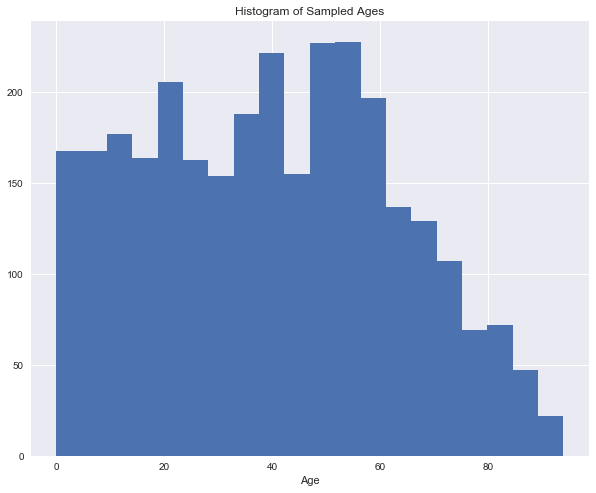

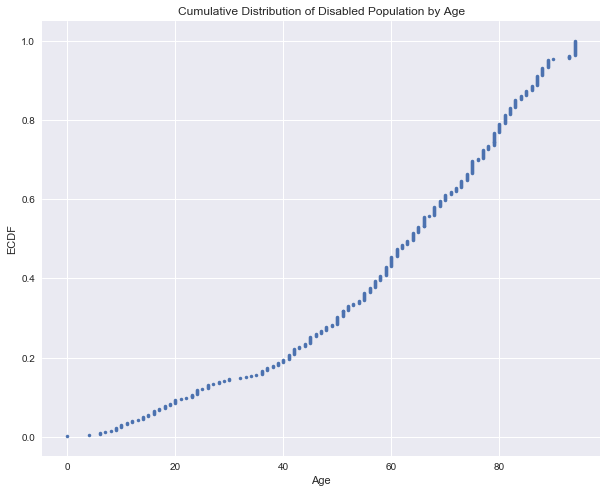

In [40]:
data.hist('AGEP',bins=20)
plt.title('Histogram of Sampled Ages')
plt.xlabel('Age')
plt.show()
plt.clf()

x,y = ecdf(data.AGEP[data['Disabled']==1])
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel('Age')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Disabled Population by Age')
plt.show()
plt.clf()

The distribution of ages of the disabled population seems to be the opposite of that of the population in whole.

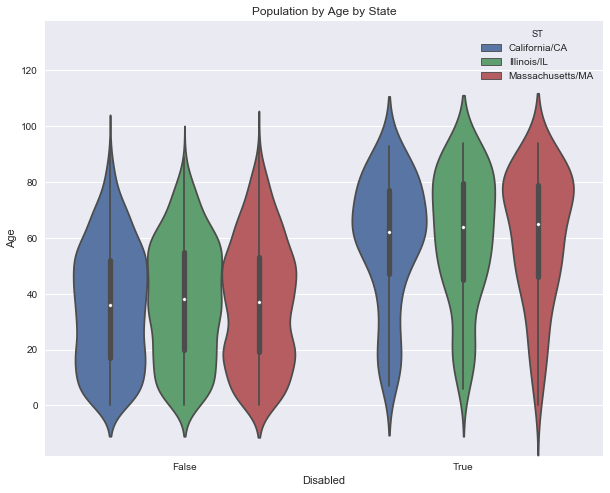

In [41]:
sns.violinplot(x='Disabled',y='AGEP',data=data,hue='ST')
plt.margins(.2)
plt.ylim(-18)
plt.ylabel('Age')
plt.title('Population by Age by State')
plt.show()
plt.clf()

The distribution of ages by state appear to be very similar.  The median of the disabled population is slightly higher as we move from West to East while the median of the non-disabled population is higher in Illinois.  I would expect that the ratio of the disabled population is higher as we move from West to East as well.

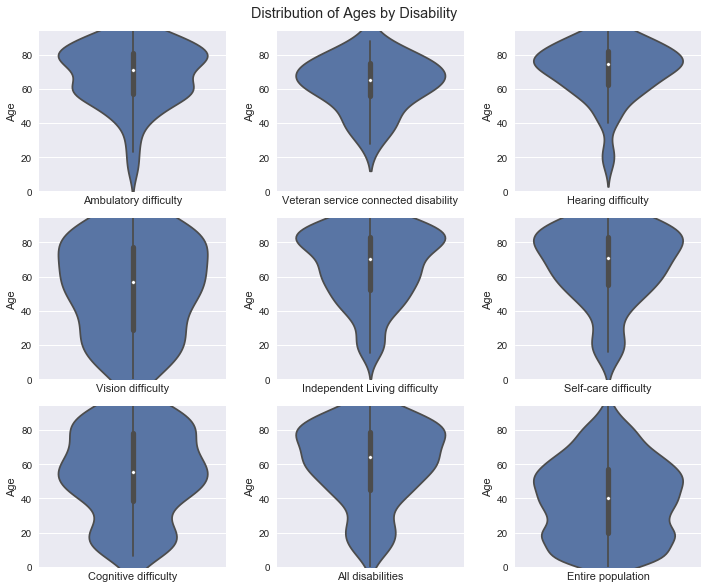

In [42]:
x=1
for i in disability_codes:
    plt.subplot(3,3,x)
    sns.violinplot(x=i,y='AGEP',data=disabled_data[disabled_data[i]==1.0])
    plt.xlabel(dictionary['Description'][i])
    plt.ylabel('Age')
    plt.ylim(data.AGEP.min(),data.AGEP.max())
    plt.xticks([],[])
    x+=1
plt.subplot(3,3,8)
sns.violinplot(y='AGEP',data=disabled_data)
plt.xlabel('All disabilities')
plt.ylabel('Age')
plt.ylim(data.AGEP.min(),data.AGEP.max())
plt.xticks([],[])
plt.subplot(3,3,9)
sns.violinplot(y='AGEP',data=data)
plt.xlabel('Entire population')
plt.ylabel('Age')
plt.ylim(data.AGEP.min(),data.AGEP.max())
plt.xticks([],[])

plt.suptitle('Distribution of Ages by Disability',y=1.02)
plt.tight_layout()
plt.show()
plt.clf()

The distribution of ages by disability appear to have significant differences.  The median age is above 60 for all but vision and cognitive disability.
Note: The min and max of the y-axis has been set to reflect that of ages for the entire population

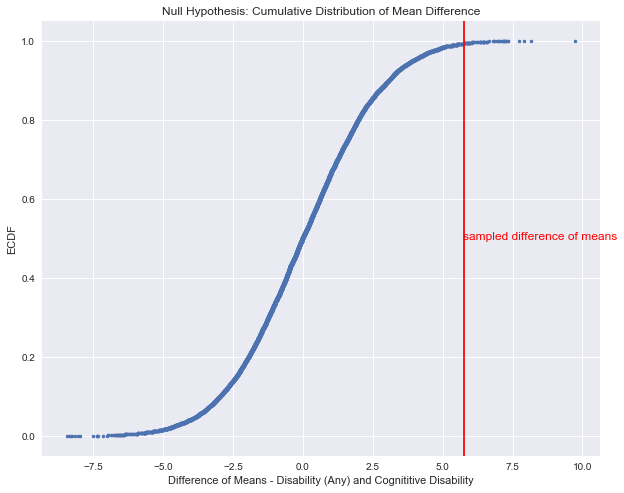

p = 0.0069
alpha = .05
Reject the null; the difference in means is statistically significant


In [43]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    return bs_replicates
cog_ages = data.AGEP[data['DREM']==1]
dis_ages = data.AGEP[data['Disabled']==1]

mean_diff = np.mean(dis_ages) - np.mean(cog_ages) 
combined_mean = np.mean(np.concatenate((cog_ages,dis_ages)))
cog_ages_shifted = cog_ages - np.mean(cog_ages) + combined_mean
dis_ages_shifted = dis_ages - np.mean(dis_ages) + combined_mean
bs_replicates_cog = draw_bs_reps(cog_ages_shifted,np.mean,10000)
bs_replicates_dis = draw_bs_reps(dis_ages_shifted,np.mean,10000)
bs_diff_replicates = bs_replicates_dis - bs_replicates_cog
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

x,y = ecdf(bs_diff_replicates)
plt.plot(x,y,marker='.',linestyle='none')
plt.axvline(x=mean_diff,color='r')
plt.title('Null Hypothesis: Cumulative Distribution of Mean Difference')
plt.xlabel('Difference of Means - Disability (Any) and Cognititive Disability')
plt.ylabel('ECDF')
plt.figtext(.71, .5, 'sampled difference of means', fontdict=None, color='r')
plt.show()
plt.clf()
print('p =', p)
print('alpha = .05')
if p>.05:
    print('Fail to reject the null; the difference in means is not statistically significant')
else:
    print('Reject the null; the difference in means is statistically significant')

Null hypothesis: The mean age of persons with cognitive difficulty is the same as the mean age of persons with any disability

Alternative hypothesis: The mean age of persons with cognitive difficulty is less than the mean age of persons with any disability

Bootstrap test: The data has been shifted so that the means are identical.  Random samples were then re-drawn from the shifted data 10,000 times, and the difference between the means was recorded.